In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

gender_submission.csv
test.csv
train.csv



In [2]:
train_data = pd.read_csv("../input/train.csv")
train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
from sklearn import preprocessing

def transSymbolEncoder(x):
    lb = preprocessing.LabelEncoder()
    lb.fit(x)
    return lb.transform(x)

def transSymbolBinary(XX, colName):
    X = XX
    x = X[colName].fillna("NA")
    lb = preprocessing.LabelBinarizer()
    lb.fit(x)
    value = lb.transform(x)
    for i in range(len(value[0])):
        X["{}_{}".format(colName, lb.classes_[i])] = value[:, i]

    return X.drop([colName], axis='columns')

def transAll(X):  
    # 缺項處理
    #train_data = train_data.dropna()
    X = X.fillna({'Age': 0, 
                'Fare': 0, 
                'Embarked': 'C'})

    # 轉換性別
    # X['Sex'] = transSymbolEncoder(X['Sex'])
    X = transSymbolBinary(X, 'Sex')
    # 轉換艙號
    X['Cabin'] = transSymbolEncoder(X['Cabin'].notnull())
    # 轉換登船港口
    # X['Embarked'] = transSymbolEncoder(X['Embarked'])
    X = transSymbolBinary(X, 'Embarked')
    # 轉換名字
    X['Name'] = X['Name'].apply(len)
    #X['Name'] = (X['Name'] - X['Name'].mean()) / X['Name'].std()
    
    X['Ticket'] = X['Ticket'].apply(len)
    
    X['Family'] = X['SibSp'] + X['Parch']
    X = X.drop(['SibSp', 'Parch'], axis='columns')
    
    #X['Age'] = (X['Age'] - X['Age'].mean()) / X['Age'].std()
    #X['Fare'] = (X['Fare'] - X['Fare'].mean()) / X['Fare'].std()
    
    return X

In [5]:
X_origin = train_data.drop(['PassengerId', 'Survived'], axis='columns')
y = train_data['Survived']

In [6]:
X = transAll(X_origin)
X.head(10)

,Pclass,Name,Age,Ticket,Fare,Cabin,Sex_female,Embarked_C,Embarked_Q,Embarked_S,Family
0,3,23,22.0,9,7.2500,0,1,0,0,1,1
1,1,51,38.0,8,71.2833,1,0,1,0,0,1
2,3,22,26.0,16,7.9250,0,0,0,0,1,0
3,1,44,35.0,6,53.1000,1,0,0,0,1,1
4,3,24,35.0,6,8.0500,0,1,0,0,1,0
5,3,16,0.0,6,8.4583,0,1,0,1,0,0
6,1,23,54.0,5,51.8625,1,1,0,0,1,0
7,3,30,2.0,6,21.0750,0,1,0,0,1,4
8,3,49,27.0,6,11.1333,0,0,0,0,1,2
9,2,35,14.0,6,30.0708,0,0,1,0,0,1


In [7]:
from sklearn.model_selection import cross_val_score  
import seaborn as sns

def evaluate_model(clf, X, y):
    # 5-Fold Cross Validation
    scores = cross_val_score(clf, X, y, cv=10)
    # 平均埴
    m = scores.mean()
    # 標準差
    sd = scores.std()
    
    # 訓練資料準確度
    clf.fit(X, y)
    score = clf.score(X, y)
    
    # 中位數
    ax = sns.boxplot(scores)
    ax.set_xlim([0.6, 0.85])
    ax.set_title("val_mean:{:.2f}, val_std:{:.4f}\ntrain_score:{:.2f}\n\nclf:{}".format(m, sd, score, clf))
    
    return clf

單一演算法

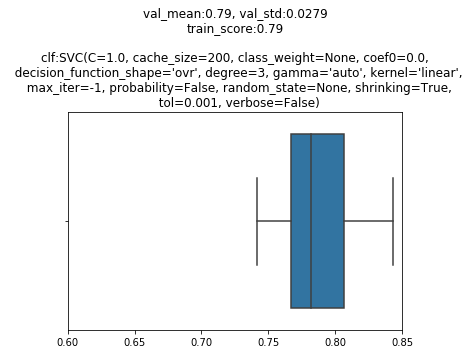

In [8]:
# 0.76555
from sklearn import svm

clf = svm.SVC(kernel='linear')
linearSVC_clf = evaluate_model(clf, X, y)

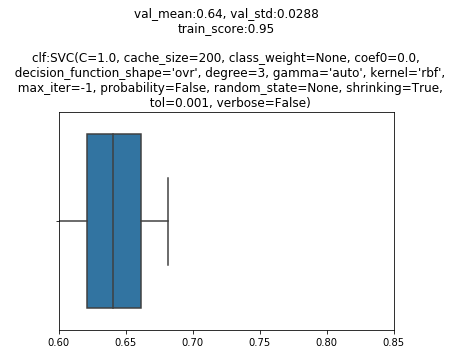

In [9]:
# 0.64593
from sklearn import svm

clf = svm.SVC(kernel='rbf')
rbfSVC_clf = evaluate_model(clf, X, y)

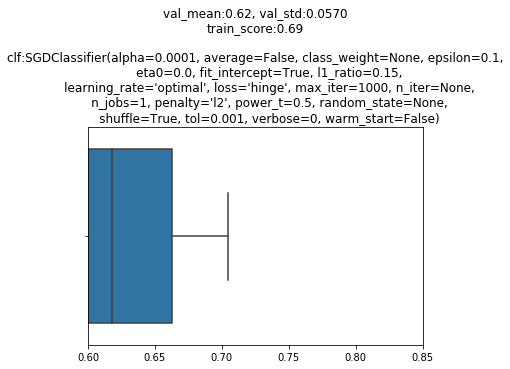

In [10]:
# 0.62679
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(max_iter=1000, tol=1e-3)
SGD_clf = evaluate_model(clf, X, y)

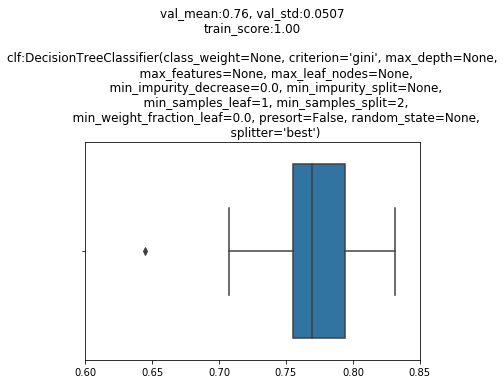

In [11]:
# 0.69377
from sklearn import tree

clf = tree.DecisionTreeClassifier()
decisionTree_clf = evaluate_model(clf, X, y)

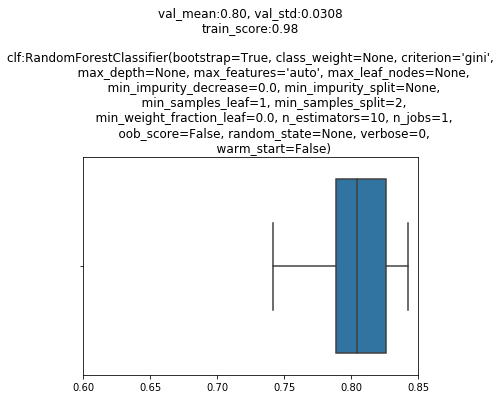

In [12]:
# 0.76555
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
randomForest_clf = evaluate_model(clf, X, y)

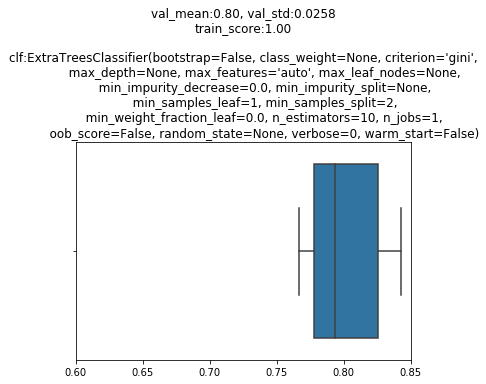

In [13]:
# 0.77511
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier()
extraTrees_clf = evaluate_model(clf, X, y)

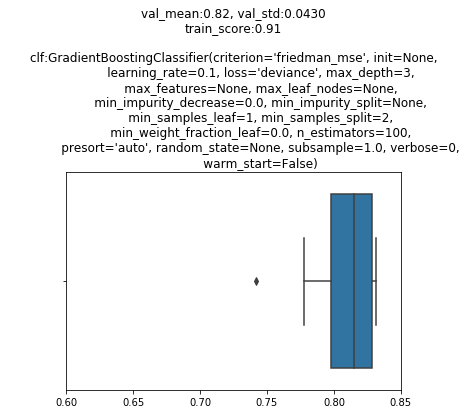

In [14]:
# 0.76076
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()
gradientBoosting_clf = evaluate_model(clf, X, y)

混合演算法

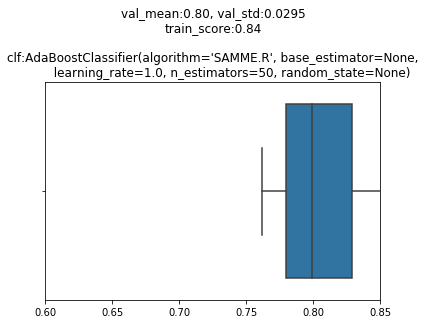

In [15]:
# 0.76555
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier()
adaBoost_clf = evaluate_model(clf, X, y)

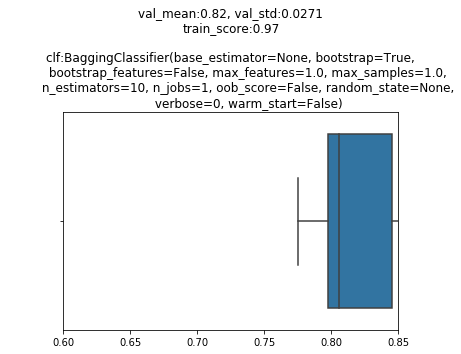

In [16]:
# 0.75119
from sklearn.ensemble import BaggingClassifier

clf = BaggingClassifier()
bagging_clf = evaluate_model(clf, X, y)

各種混合實驗

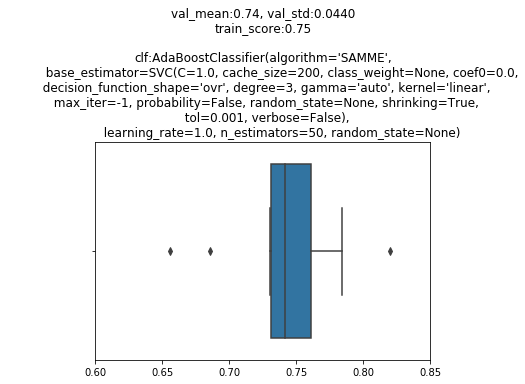

In [17]:
# 0.69856
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier

clf = svm.SVC(kernel='linear')
clf = AdaBoostClassifier(base_estimator=clf, algorithm='SAMME')
linearSVC_adaBoost_clf = evaluate_model(clf, X, y)

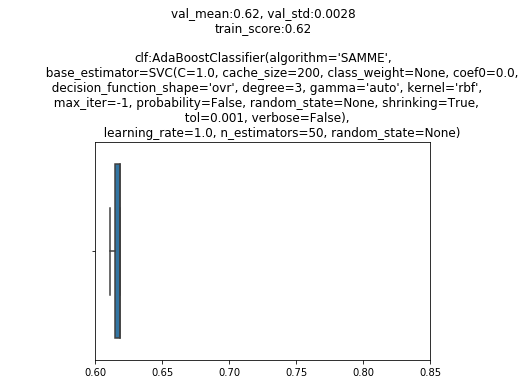

In [18]:
# 0.62679
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier

clf = svm.SVC(kernel='rbf')
clf = AdaBoostClassifier(base_estimator=clf, algorithm='SAMME')
rbfSVC_adaBoost_clf = evaluate_model(clf, X, y)

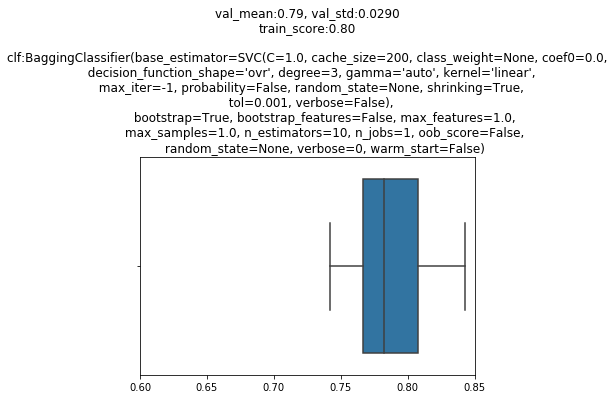

In [19]:
# 0.76555
from sklearn import svm
from sklearn.ensemble import BaggingClassifier

clf = svm.SVC(kernel='linear')
clf = BaggingClassifier(base_estimator=clf)
linearSVC_Bagging_clf = evaluate_model(clf, X, y)

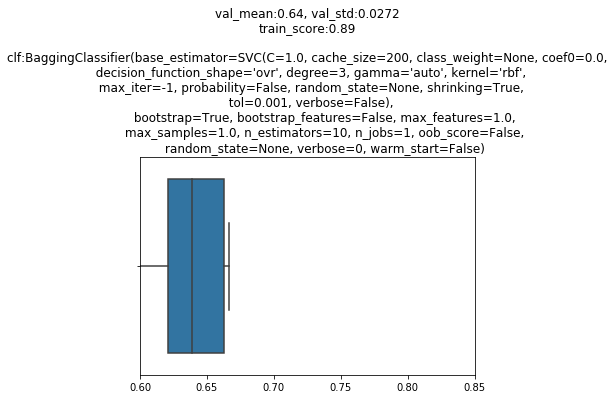

In [20]:
# 0.63157
from sklearn import svm
from sklearn.ensemble import BaggingClassifier

clf = svm.SVC(kernel='rbf')
clf = BaggingClassifier(base_estimator=clf)
rbfSVC_bagging_clf = evaluate_model(clf, X, y)

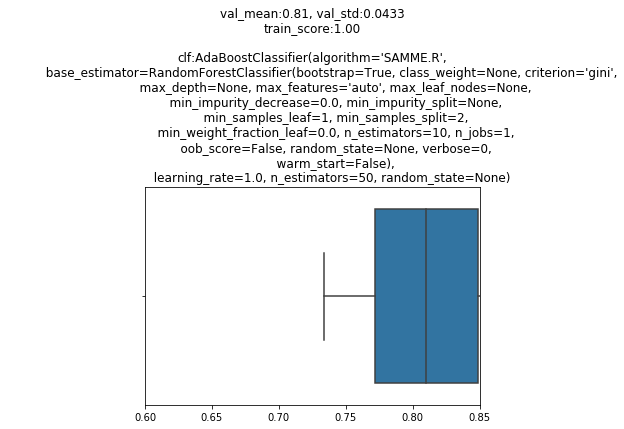

In [21]:
# 0.71770
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

clf = RandomForestClassifier()
clf = AdaBoostClassifier(base_estimator=clf)
randomForest_adaBoost_clf = evaluate_model(clf, X, y)

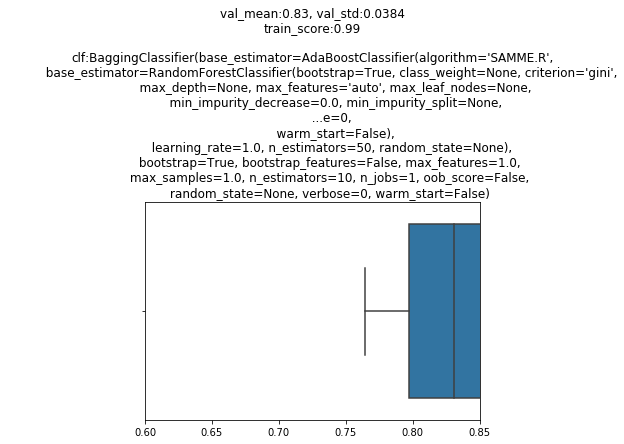

In [22]:
# 0.76555
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

clf = RandomForestClassifier()
clf = AdaBoostClassifier(base_estimator=clf)
clf = BaggingClassifier(base_estimator=clf)
randomForest_adaBoost_bagging_clf = evaluate_model(clf, X, y)

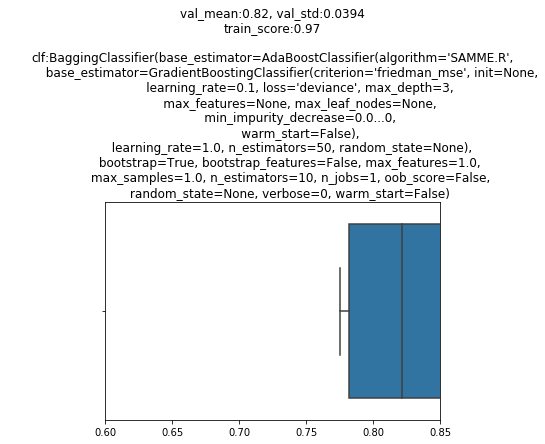

In [23]:
# 0.74162
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

clf = GradientBoostingClassifier()
clf = AdaBoostClassifier(base_estimator=clf)
clf = BaggingClassifier(base_estimator=clf)
gradientBoost_adaBoost_bagging_clf = evaluate_model(clf, X, y)

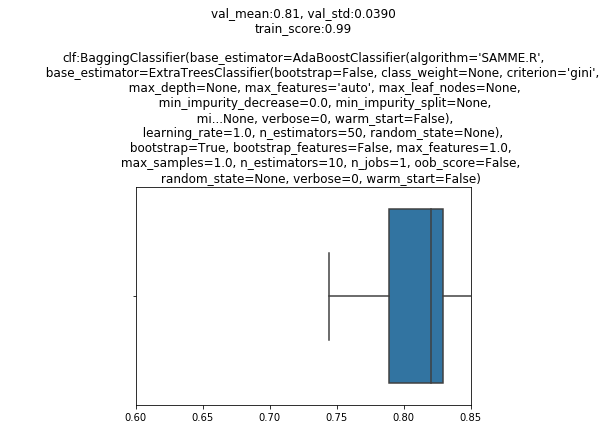

In [24]:
# 0.77511
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

clf = ExtraTreesClassifier()
clf = AdaBoostClassifier(base_estimator=clf)
clf = BaggingClassifier(base_estimator=clf)
extraTrees_adaBoost_bagging_clf = evaluate_model(clf, X, y)

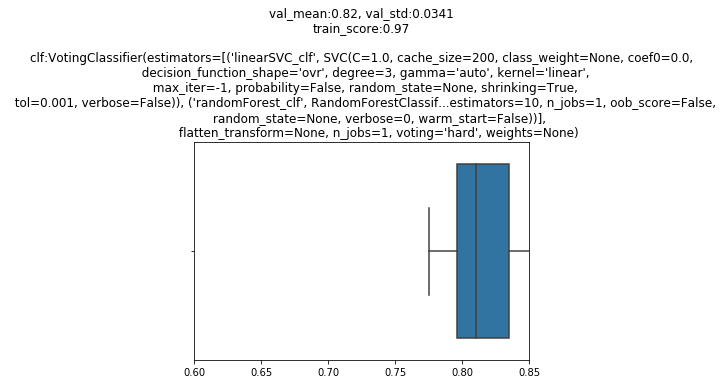

In [25]:
# 0.75598
from sklearn.ensemble import VotingClassifier

estimators=[("linearSVC_clf", linearSVC_clf), 
            ("randomForest_clf", randomForest_clf), 
            ("extraTrees_clf", extraTrees_clf), 
            ("gradientBoosting_clf", gradientBoosting_clf),
            ("adaBoost_clf", adaBoost_clf), 
            ("bagging_clf", bagging_clf),
            ("linearSVC_Bagging_clf", linearSVC_Bagging_clf), 
            ("randomForest_adaBoost_bagging_clf", randomForest_adaBoost_bagging_clf), 
            ("gradientBoost_adaBoost_bagging_clf", gradientBoost_adaBoost_bagging_clf), 
            ("extraTrees_adaBoost_bagging_clf", extraTrees_adaBoost_bagging_clf)]
clf = VotingClassifier(estimators=estimators, voting='hard')
votingHard = evaluate_model(clf, X, y)

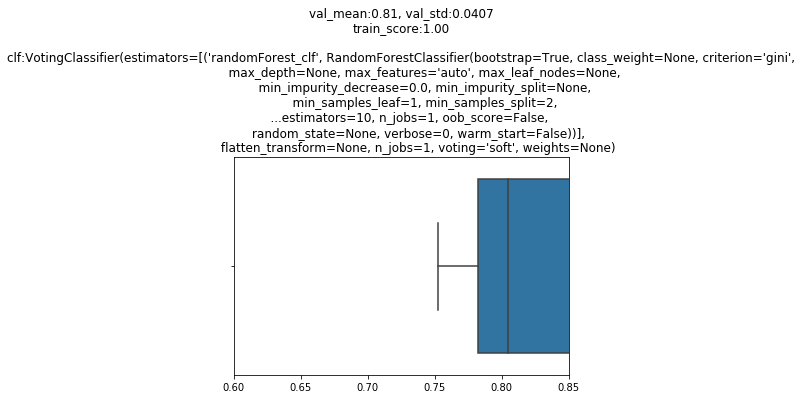

In [26]:
# 0.75598
from sklearn.ensemble import VotingClassifier

estimators=[("randomForest_clf", randomForest_clf), 
            ("extraTrees_clf", extraTrees_clf), 
            ("gradientBoosting_clf", gradientBoosting_clf),
            ("adaBoost_clf", adaBoost_clf), 
            ("bagging_clf", bagging_clf),
            ("randomForest_adaBoost_bagging_clf", randomForest_adaBoost_bagging_clf), 
            ("gradientBoost_adaBoost_bagging_clf", gradientBoost_adaBoost_bagging_clf), 
            ("extraTrees_adaBoost_bagging_clf", extraTrees_adaBoost_bagging_clf)]
clf = VotingClassifier(estimators=estimators, voting='soft')
votingSoft= evaluate_model(clf, X, y)

結果

In [27]:
clf_final = votingSoft

In [28]:
test_data = pd.read_csv("../input/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [29]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [30]:
X_test = test_data.drop(['PassengerId'], axis=1)
X_test = transAll(X_test)
X_test.head()

,Pclass,Name,Age,Ticket,Fare,Cabin,Sex_female,Embarked_C,Embarked_Q,Embarked_S,Family
0,3,16,34.5,6,7.8292,0,1,0,1,0,0
1,3,32,47.0,6,7.0000,0,0,0,0,1,1
2,2,25,62.0,6,9.6875,0,1,0,1,0,0
3,3,16,27.0,6,8.6625,0,1,0,0,1,0
4,3,44,22.0,7,12.2875,0,0,0,0,1,2


In [31]:
y_predict = clf_final.predict(X_test)

In [32]:
results = pd.DataFrame({
    'PassengerId' : test_data['PassengerId'],
    'Survived' : y_predict
 })
results.to_csv("output.csv", index=False)